In [1]:
NetID = ""

Name: Shuyue Lai
Status: Registered

# Part A: Parsing

In [2]:
# read in pf.log
with open('pf.log', 'r' ) as f:
    lines = f.readlines()

# strip all lines of whitespace
lines = [line.strip() for line in lines]     
# for line in lines:
#     print(line)

In [3]:
# parse each line into your data structure
# remember to convert addresses from strings to integers
index = 0    # index of csv
i = 0        # index of line
length = len(lines)    # length of input

outputs = []
    
while(i != length):
    value1 = lines[i].split(':')    # 1506816069251:firefox:13179:0x282235aae:R:minor:50
    # print(value1)
    i = i + 1
    index = index + 1
    while(i != length and lines[i][0] == '<'):     # </usr/lib/x86_64-linux-gnu/libcairo.so.2.11400.10+0xa7b5f/0xff3f00>
        value2 = lines[i].split('+')
        lib = value2[0].strip('<')
        value3 = value2[1].split('/')
        offset = int(value3[0], 16)
        addr = int(value3[1].strip('>'), 16)
        result = '\t'.join([str(index), value1[0], value1[1], value1[2], str(int(value1[3], 16)), value1[4], value1[5], value1[6], lib, str(addr), str(offset)])
        # print(result)          
        i = i + 1
        outputs.append(result)

In [4]:
# write your data structure out to pf.csv
# include an index column with unique indices for each page fault
with open('pf.csv', 'w') as f:
    # write header line
    f.write('\t'.join(['index', 'time', 'proc_name', 'pid', 'pfaddr', 'rw', 'major_minor', 'resolve_time', 'lib', 'addr', 'offset']))
    f.write('\n')
    
    # write each page fault & backtrace entry
    # hint: take a look at python's enumerate() function to generate indices
    # Remember that indices should be unique to each page fault
    for output in outputs:
        f.write(output)
        f.write('\n')

# Part B: Analysis

In [5]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

In [6]:
# relevant options when reading in pf.csv: sep, parse_dates
df = pd.read_csv('pf.csv', sep = '\t', parse_dates = ['time'])
# df['time'] = pd.to_datetime(df['time'])

# set the index of the data frame
df.set_index(df['index'], inplace=True)

### a. 
What time range does this data cover?

In [7]:
min_time = pd.to_datetime(df['time'], unit='ms').min()
max_time = pd.to_datetime(df['time'], unit='ms').max()
range_time = max_time - min_time
print("start date:", min_time)
print("end date:", max_time)
print("time range:", range_time)

start date: 2017-10-01 00:01:09.251000
end date: 2018-01-07 18:59:50.839000
time range: 98 days 18:58:41.588000


### b. 
How many unique processes were executed over this period? How many times was each process executed?

In [8]:
proc_name = set(df['proc_name'])
print(len(proc_name))

counter = df['index'].groupby(df['proc_name']).unique()
for i in range(len(counter)):
    print(counter.index[i], len(counter[i]))

12
auditd 57185
bash 57427
firefox 58289
gitlab-runner 54543
google-chrome 59596
htop 58304
sshd 61721
subl 61746
thunderbird 59393
tmux 54661
watchdog 58839
xorg 61072


### c. 
Compare the number of major & minor page faults for each process (averaged over all runs). Plot a bar chart with two categories ‑ major &
minor, to demonstrate your results.

auditd major 5701
auditd minor 51484
bash major 5713
bash minor 51714
firefox major 5991
firefox minor 52298
gitlab-runner major 5291
gitlab-runner minor 49252
google-chrome major 5938
google-chrome minor 53658
htop major 5902
htop minor 52402
sshd major 6089
sshd minor 55632
subl major 6129
subl minor 55617
thunderbird major 5857
thunderbird minor 53536
tmux major 5478
tmux minor 49183
watchdog major 5872
watchdog minor 52967
xorg major 6078
xorg minor 54994


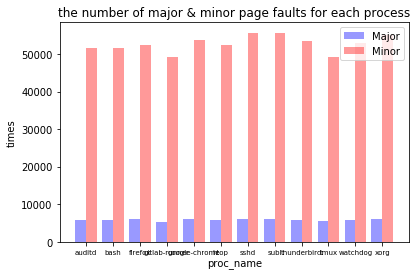

In [9]:
process = df['index'].groupby([df['proc_name'], df['major_minor']]).unique()

list_process_name = []
major_val = []
minor_val = []

for i in range(len(process)):
    cur_process_name = process.index[i][0]
    cur_name = process.index[i][1]
    cur_val = len(process[i])
    print(cur_process_name, cur_name, cur_val)
    if cur_name == 'major':
        list_process_name.append(cur_process_name)
        major_val.append(cur_val)
    else:
        minor_val.append(cur_val)

fig, ax = plt.subplots()
n_groups = len(list_process_name)
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.4

rects1 = ax.bar(index, major_val, bar_width,
                alpha=opacity, color='b',
                label='Major')
rects2 = ax.bar(index + bar_width, minor_val, bar_width,
                alpha=opacity, color='r',
                label='Minor')

ax.set_xlabel('proc_name')
ax.set_ylabel('times')
ax.set_title('the number of major & minor page faults for each process')
ax.set_xticks(index + bar_width/2)
ax.set_xticklabels(list_process_name)
ax.legend()

fig.tight_layout()
plt.xticks(fontsize = 7)
plt.show()

### d. 
Plot the histogram for the time to resolve page faults. Label the axes. For each process, report the mean and standard deviation of the time
to resolve page faults. Plotting and calculations should be done for major and minor page faults separately.

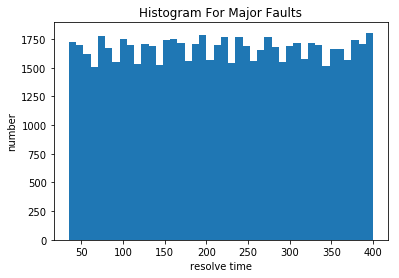

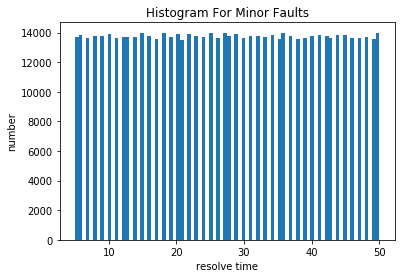

In [10]:
df_index_unique = df.groupby(df['index']).head(1)
major_hist = list(df_index_unique[df_index_unique['major_minor'] == 'major']['resolve_time'])
minor_hist = list(df_index_unique[df_index_unique['major_minor'] == 'minor']['resolve_time'])

plt.hist(major_hist, bins='auto')
plt.ylabel('number')
plt.xlabel('resolve time')
plt.title('Histogram For Major Faults')
plt.show()

plt.hist(minor_hist, bins='auto')
plt.ylabel('number')
plt.xlabel('resolve time')
plt.title('Histogram For Minor Faults')
plt.show()

auditd major mean: 217.74495702508332 std: 105.35906622785735
auditd minor mean: 27.52037526221739 std: 13.286257258669712
bash major mean: 217.9333099947488 std: 105.21799066066299
bash minor mean: 27.441137796341415 std: 13.27484236956508
firefox major mean: 220.67785010849607 std: 104.52043936727114
firefox minor mean: 27.571360281463917 std: 13.276757678780305
gitlab-runner major mean: 213.84048384048384 std: 106.11060977256928
gitlab-runner minor mean: 27.37474620319987 std: 13.26370137953019
google-chrome major mean: 218.56416301785112 std: 104.98036266868435
google-chrome minor mean: 27.508144172350814 std: 13.230825904103908
htop major mean: 218.407319552694 std: 104.72779963102408
htop minor mean: 27.42723560169459 std: 13.277470988175734
sshd major mean: 216.40532107078337 std: 105.3689123905007
sshd minor mean: 27.506794650560828 std: 13.299933666952612
subl major mean: 215.4346549192364 std: 105.69754011721432
subl minor mean: 27.445493284427425 std: 13.255274351430309
thun

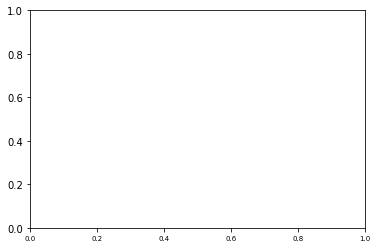

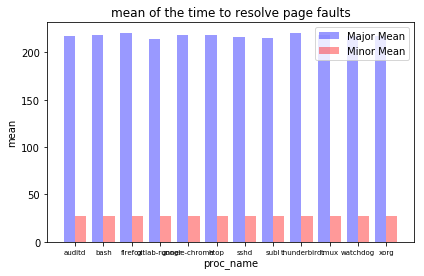

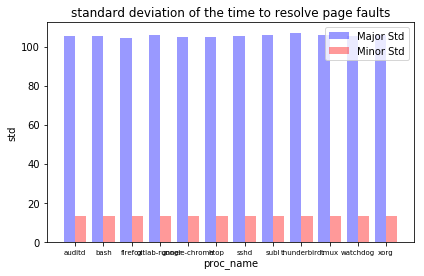

In [12]:
resolve_time = df['index'].groupby([df['proc_name'], df['major_minor']]).unique()

list_process_name = []
major_mean = []
major_std = []
minor_mean = []
minor_std = []

for i in range(len(resolve_time)):
    cur_process_name = resolve_time.index[i][0]
    cur_name = resolve_time.index[i][1]
    cur_mean = df_index_unique[(df_index_unique['index'].isin(list(resolve_time[i])))]['resolve_time'].mean()
    cur_std = df_index_unique[(df_index_unique['index'].isin(list(resolve_time[i])))]['resolve_time'].std()
    print(cur_process_name, cur_name, "mean:", cur_mean, "std:", cur_std)
    if cur_name == 'major':
        list_process_name.append(cur_process_name)
        major_mean.append(cur_mean)
        major_std.append(cur_std)
    else:
        minor_mean.append(cur_mean)
        minor_std.append(cur_std)

fig, ax = plt.subplots()
n_groups = len(list_process_name)
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.4

rects1 = ax.bar(index, major_mean, bar_width,
                alpha=opacity, color='b',
                label='Major Mean')
rects2 = ax.bar(index + bar_width, minor_mean, bar_width,
                alpha=opacity, color='r',
                label='Minor Mean')

ax.set_xlabel('proc_name')
ax.set_ylabel('mean')
ax.set_title('mean of the time to resolve page faults')
ax.set_xticks(index + bar_width/2)
ax.set_xticklabels(list_process_name)
ax.legend()

fig.tight_layout()
plt.xticks(fontsize = 7)
plt.show()

fig, ax = plt.subplots()
n_groups = len(list_process_name)
index = np.arange(n_groups)
bar_width = 0.4
opacity = 0.4

rects1 = ax.bar(index, major_std, bar_width,
                alpha=opacity, color='b',
                label='Major Std')
rects2 = ax.bar(index + bar_width, minor_std, bar_width,
                alpha=opacity, color='r',
                label='Minor Std')

ax.set_xlabel('proc_name')
ax.set_ylabel('std')
ax.set_title('standard deviation of the time to resolve page faults')
ax.set_xticks(index + bar_width/2)
ax.set_xticklabels(list_process_name)
ax.legend()

fig.tight_layout()
plt.xticks(fontsize = 7)
plt.show()


